## Tabular Playground Series May 2021 
### Complete Step by Step guide to approaching the Problem 

**Description of what you are going to find in the notebook**

In the problem I have used a lightgbm model with a 5 fold stratefied cross validation. For finding the best hyperparameters I have used the optuna library with 10 trials.For the metric I have used logloss and in the next version I will be using AUCROC curve. A very basic data visualization and feature engineering has been done as well.  This is just a starter notebook and a lot of improvements are going to be made in this like dimensionality reduction, better hyperparameter optimisation and training with more folds for better validation. 



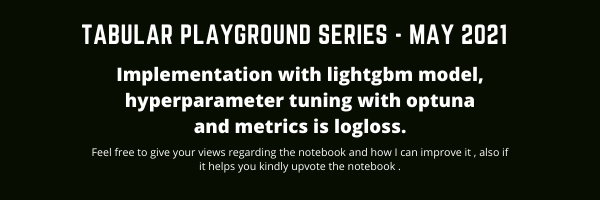


### Importing the Libraries and Loading the data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,accuracy_score
import optuna
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')
sns.set_color_codes(palette='deep')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
df_train.describe()

In [ ]:
df_train['target'].value_counts()

### Basic Data Visualization

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)
sns.countplot(df_train['target'])

**From the aobve plot we can say that there is a chance that the data in imbalanced, however, I will try to deal with it in a future version**

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(df_train.corr())

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plt.subplot(1, 3, 1)
sns.distplot(df_train['feature_0'],kde=True,color = 'white',hist=True)
plt.subplot(1,3,2)
sns.distplot(df_train['feature_25'],kde=True,color = 'white',hist=True)
plt.subplot(1,3,3)
sns.distplot(df_train['feature_49'],kde=True,color = 'white',hist=True)
plt.suptitle('Distribution of three features out of 50')

**From the following feature distribution we can say that these three features are a little left skewed. On going through the distribution of all the features,we will see that most of them are left skewed.**

### Feature Engineering

In [ ]:
# Replacing the class 1 as 0, class 2 as 1 and so on. I have used the replace function on can use the mapping function as well
df_train['target'] = df_train['target'].replace({'Class_1':0,'Class_2':1,'Class_3':2,'Class_4':3})

In [ ]:
# Checking for missing values
df_train.isnull().sum()

In [ ]:
# Splitting the training data into train and test halves. 
train,test = train_test_split(df_train,test_size = 0.1,shuffle=True)

In [ ]:
train.head()

In [ ]:
# Creating a target column
target = train.pop('target')
# removing the id column from both train and test as it is of not much use
train.pop('id')
test.pop('id')

### Hyperparameter Tuning

In [ ]:
# creating the object function of the optuna
def objective(trial,data=train,target = target):
    # defining the parameters for lgbm
    param = {
        "objective": "multiclass",
        "num_class":4,
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    # Initializing a array for storing all the accuracy scores
    acc = []
    # making the cross validation split
    kf = model_selection.StratifiedKFold(n_splits=5)
    # Starting the cross validation loop
    for train_index, test_index in kf.split(train,target):
        # Storing the data in my favoured way
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = target.iloc[train_index],target.iloc[test_index]
        # Creating the dataset for passing it to the lbg model. 
        dtrain = lgb.Dataset(X_train,y_train)
        # training the model
        gbm = lgb.train(param, dtrain)
        # The predict function here returns the probabilities of each class unlike that of the sklearn version
        preds = gbm.predict(X_test)
        # Converting the probabilities to predictions
        pred_labels = [np.argmax(line) for line in preds]
        # calculating the accuracy score
        accuracy = accuracy_score(y_test,pred_labels)
        acc.append(accuracy)
    print(np.average(acc))
    return np.average(acc)

In [ ]:
# creating the study for optuna
study = optuna.create_study(study_name = 'lgbm_parameter_opt', direction="maximize")
study.optimize(objective,n_trials=10) 

In [ ]:
# Selecting the best parameters according to the above optimisation
best_params = study.best_trial.params

In [ ]:
# Adding a few more parameters that are not trainable to the best_parameters dictionary
best_params['objective'] = 'multiclass'
best_params['num_class'] = 4
best_params['metric'] = 'multi_logloss'

In [ ]:
df_test.head()

In [ ]:
df_test.pop('id')

In [ ]:
df_test.head()

### Compiling the Final model

In [ ]:
test=[]
logloss_arr = []
# Making the final training
kf = model_selection.StratifiedKFold(n_splits=5)
for train_index, test_index in kf.split(train,target):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target.iloc[train_index],target.iloc[test_index]
    dtrain = lgb.Dataset(X_train,y_train)
    fgbm = lgb.train(best_params, dtrain)
    preds = fgbm.predict(X_test)
    logloss = log_loss(y_test,preds)
    logloss_arr.append(logloss)
    
    
test.append(fgbm.predict(df_test))

# One thing I missed that I realized while doing the final compilation is that I have not calculated any metrics on the initial test halve which should have been done here. 


In [ ]:
logloss_arr

### Submission

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')

In [ ]:
submission.head()

In [ ]:
test

In [ ]:
test_predictions = np.mean(test, axis = 0)
assert len(test_predictions) == len(df_test)

In [ ]:
predictions_df = pd.DataFrame(test_predictions, columns = ["Class_1", "Class_2", "Class_3", "Class_4"])

In [ ]:
predictions_df.to_csv("submission.csv", index = False)

In [ ]:
predictions_df['id'] = submission['id']


In [ ]:
predictions_df.to_csv("submission.csv", index = False)